# Projeto 2 - Ciência dos Dados
## Predição do preço de imóveis brasileiros

Nome: Ananda Julia Galvão Campelo

Nome: Carol Magario de Mattos Barretto

Nome: Rafael Dourado Bastos de Oliveira

___
Carregando as bibliotecas necessárias:

In [710]:
%matplotlib inline
import pandas as pd
import numpy as np
import math
import os

# Bibliotecas de modelos estatísticos
from scipy import stats

import statsmodels.api as sm
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Bibliotecas gráficas para facilitar a vizualização dos dados
import matplotlib.pyplot as plt
import seaborn as sn
from IPython.display import display

# Biblioteca que remove os warnings do Jupter Notbook para uma vizualização mais limpa do documento
import warnings
warnings.filterwarnings('ignore')

In [711]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
c:\Users\Rafael Dourado\Desktop\Programação\Insper\cdados\22-2c-cd-p2-grupo_dj_lovers\notebooks


Carregando as funções necessárias:

In [712]:
# Função que separa os base de dados em Treino e Teste
def generate_random_train_test(data, percent_train=1, random_seed=1):

    # randam_state = None : dados aleátorios
    data = data.sample(frac=1.0, random_state=random_seed)

    n_real = len(data)
    n_treino = math.floor(n_real * percent_train)

    train = data.iloc[:n_treino].reset_index(drop=True)
    test = data.iloc[n_treino:].reset_index(drop=True)

    print('Bases de Treino e Teste geradas com sucesso!')
    print(f'A base de Treino possui {train.shape[0]} conjuntos de dados\nA base de Teste possui {test.shape[0]} conjuntos de dados')
    return train, test


Carregando a base com todos dados:

In [713]:
path = '../data/'
filename = 'houses_to_rent.csv'

data = pd.read_csv(path+filename, sep=",")

* *city*: Cidade onde o imóvel está localizada
* *area*: Area do imovel [m²]
* *rooms*: Número de quartos 
* *bathroom*: Número de banheiros
* *parking spaces*: Número de vagas no estacionamento
* *floor*: Andar em que está localizado
* *animal*: Aceita animais? [acept/not acept]
* *furniture*: Está Mobilhada? [furnished/not furnished]
* *hoa*: Valor do Condominio [R$]
* *rent amount*: Valor do Aluguel [R$]
* *property tax*: IPTU [R$]
* *fire insurance*: Seguro Incendio [R$]
* *total*: Valor Total do Imóvel [R$]


In [714]:
data.head()

,city,area,rooms,bathroom,parking_spaces,floor,animal,furniture,hoa,rent_amount,property_tax,fire_insurance,total
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836


____
### Primeiras Simplificações

Um estudo rápido dos dados revelou a variavel  `total` é composta da soma das variáveis `hoa`, `rent_amount`, `property_tax` e `fire_insurance`. Por isso, uma simplificação inicial do modelo que tentará descobrir o valor de uma apartamento será utilizar como **variavel Target** o `rent_amount` (valor do aluguel) e descartar as demais variaveis supracitadas durante a analise.

In [715]:
data = data.drop(['hoa', 'property_tax', 'fire_insurance', 'total'], axis=1)
data.head()

,city,area,rooms,bathroom,parking_spaces,floor,animal,furniture,rent_amount
0,São Paulo,70,2,1,1,7,acept,furnished,3300
1,São Paulo,320,4,4,0,20,acept,not furnished,4960
2,Porto Alegre,80,1,1,1,6,acept,not furnished,2800
3,Porto Alegre,51,2,1,0,2,acept,not furnished,1112
4,São Paulo,25,1,1,0,1,not acept,not furnished,800


_____
### Análise Exploratória

In [716]:
data.describe().round(2)

,area,rooms,bathroom,parking_spaces,rent_amount
count,10692.00,10692.00,10692.00,10692.00,10692.00
mean,149.22,2.51,2.24,1.61,3896.25
std,537.02,1.17,1.41,1.59,3408.55
min,11.00,1.00,1.00,0.00,450.00
25%,56.00,2.00,1.00,0.00,1530.00
50%,90.00,2.00,2.00,1.00,2661.00
75%,182.00,3.00,3.00,2.00,5000.00
max,46335.00,13.00,10.00,12.00,45000.00


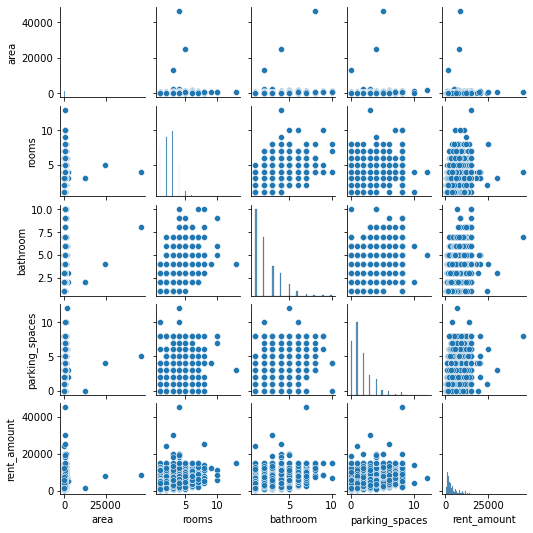

In [717]:
display(sn.pairplot(data, height=1.5))

_____
## Modelos de Predição 

Para realizar a predição do valor de apartamentos brasileiros iremos testar 4 tipos de modelos, são eles: `Regrssão linear Multipla`, `Árvore de Decisão`, `Floresta Aleatória` e `K-vizinhos mais próximos`. Nessa sessão iremos explicar brevimente o funcionamento de cada modelo e declarar as funções necessárias para utiliza-los.

### Regressão Linear Multipla 

Breve explicação de regressão linear multipla

In [718]:
# Função de regressão linear com uso da StatsModels
def linear_regress(Y,X):
    
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    
    return results

### Árvore de Decisão

Breve explicação de regressão por arvore de decisão

In [719]:
# Função de regressão por arvore de decisão com uso do SKlearn
def decision_tree_regress(X, y):

    result = DecisionTreeRegressor(random_state = 0) # Constroi a árvore
    result.fit(X, y) # Treina a árvore

    return result

### Floresta Aleatória

Breve explicação de regressão por floresta aleatória

In [720]:
# Função de regressão por floresta aleatória com uso do SKlearn
def random_forest_regress(X, y):

    result = RandomForestRegressor(random_state = 0) # Constroi a floresta
    result.fit(X, y) # Treina a floresta

    return result

### K-Vizinhos Mais Próximos

Breve explicação de regressão pelos k-vizinhos mais próximos

In [721]:
# Função de regressão por k-vizinhos mais próximos com uso do SKlearn
def K_neighbors_regress(X, y, k):

    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)

    result = KNeighborsRegressor(n_neighbors=k, metric='euclidean')
    result.fit(X, y)

    return result

## Técnicas de Análise de desempenho

Para entender a eficácia dos modelos testados serão usadas 3 técnicas de análise de desempenho, são elas: `Raiz do Erro Quadrático Médio (RMSE)`, `Coeficiente de Determinação (R2)` e `Erro Médio Absoluto (MAE)`. Para facilitar a aplicação dessas técnicas será usada a biblioteca `sklearn.metrics` que já possui funções prontas para calcula-las. A cada iteração serão calculados os erros de cada modelo e armazenados em  um DataFrame de erros para comparações e conclusões finais.

### Raiz do Erro Quadrático Médio (RMSE)

Breve explicação de Raiz do Erro Quadrático Médio (RMSE)

### Coeficiente de Determinação (R2)

Breve eplicação de Coeficiente de Determinação (R2)

### Erro Médio Absoluto (MAE)

Breve explicação de Erro Médio Absoluto (MAE)

In [722]:
errors = pd.DataFrame()
errors['type'] = ['rmse', 'mae', 'r2']

____
## Modelagem do Problema

### Primeira Iteração
 Inicialmente iremos trabalhar apenas com variaveis qualitativas para fins de simplificação inicial do Modelo. Para isso, as váriaveis  `city`, `animal` e `furniture` serão desconsideradas nessa primeira iteração. Além disso, a variavel `floor` possui  alguns valores "**-**" que representa os apartamentos localizados no térreo, como queremos trabalhar apenas com variaveis quantitativas iremos substituir esses valores por "**0**".

In [723]:
data.loc[(data['floor'] == '-'), 'floor'] = 0
data['floor'] = data['floor'].astype('int64')

quantitative_data = data[['area', 'rooms', 'bathroom', 'parking_spaces', 'floor', 'rent_amount']]

quantitative_data.head()

,area,rooms,bathroom,parking_spaces,floor,rent_amount
0,70,2,1,1,7,3300
1,320,4,4,0,20,4960
2,80,1,1,1,6,2800
3,51,2,1,0,2,1112
4,25,1,1,0,1,800


 Sendo assim, na primeira iteração feita para prever o **valor do aluguel de um apartamento (rent_amount)**, nossa `Variável Target` serão usadas como `Variáveis Features` apenas variaveis quantitativas, são elas:

 * *area*;
 * *rooms*;
 * *bathroom*;
 * *parking spaces*;
 * *floor*;

In [724]:
# Separando o Base de dados em bases de treino e teste
train, test = generate_random_train_test(quantitative_data, percent_train=0.7)

X_train = train[['area', 'rooms', 'bathroom', 'parking_spaces', 'floor']]
y_train = train['rent_amount']

X_test = test[['area', 'rooms', 'bathroom', 'parking_spaces', 'floor']]
y_test = test['rent_amount']

Bases de Treino e Teste geradas com sucesso!
A base de Treino possui 7484 conjuntos de dados
A base de Teste possui 3208 conjuntos de dados


In [725]:
# Utilizando o modelo de regressão linear multipla
linear = linear_regress(y_train, X_train)
y_pred = linear.predict(sm.add_constant(X_test))
linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            rent_amount   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.482
Method:                 Least Squares   F-statistic:                     1392.
Date:                Thu, 01 Dec 2022   Prob (F-statistic):               0.00
Time:                        20:39:17   Log-Likelihood:                -68981.
No. Observations:                7484   AIC:                         1.380e+05
Df Residuals:                    7478   BIC:                         1.380e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -296.8664     75.092     -3.953      0.000    -444.068    -149.665
area               0.1064      0.053      2.022      0.043       0.003       0.210
rooms            281.7601     36.667      7.684      0.000     209.882     353.638
bathroom        1111.8071     33.432     33.256      0.000    1046.271    1177.343
parking_spaces   418.9443     25.574     16.382      0.000     368.812     469.077
floor             61.6730      5.321     11.591      0.000      51.242      72.104
==============================================================================
Omnibus:                     2985.277   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26424.665
Skew:                           1.670   Prob(JB):                         0.00
Kurtosis:                      11.578   Cond. No.                     1.60e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.6e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

A área foi retirada por conta de seu valor-p que tá acima do desejado que seria de 0,1%.


In [726]:
# Utilizando o modelo de regressão linear multipla
linear = linear_regress(y_train, X_train.drop(['area'], axis=1))
y_pred = linear.predict(sm.add_constant(X_test.drop(['area'], axis=1)))
linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            rent_amount   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     1738.
Date:                Thu, 01 Dec 2022   Prob (F-statistic):               0.00
Time:                        20:39:17   Log-Likelihood:                -68983.
No. Observations:                7484   AIC:                         1.380e+05
Df Residuals:                    7479   BIC:                         1.380e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -302.7787     75.050     -4.034      0.000    -449.899    -155.659
rooms            282.7487     36.671      7.710      0.000     210.862     354.635
bathroom        1119.2828     33.234     33.679      0.000    1054.136    1184.430
parking_spaces   420.9105     25.561     16.467      0.000     370.804     471.017
floor             61.5389      5.322     11.564      0.000      51.107      71.971
==============================================================================
Omnibus:                     2990.536   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26374.422
Skew:                           1.675   Prob(JB):                         0.00
Kurtosis:                      11.565   Cond. No.                         22.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [727]:
# Armazenando os erros
errors['linear_1'] = [mean_squared_error(y_test, y_pred, squared=False), mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)]

In [728]:
# Utilizando o modelo de regressão por árvore de decisão
decision_tree = decision_tree_regress(X_train, y_train)
y_pred = decision_tree.predict(X_test)

# Armazenando os erros
errors['decision_tree_1'] = [mean_squared_error(y_test, y_pred, squared=False), mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)]

In [729]:
# Utilizando o modelo de regressão por floresta aleatória
random_forest = random_forest_regress(X_train, y_train)
y_pred = random_forest.predict(X_test)

# Armazenando os erros
errors['random_forest_1'] = [mean_squared_error(y_test, y_pred, squared=False), mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)]

In [730]:
# Utilizando o modelo de regressão por k-vizinhos mais próximos
K_neighbors = K_neighbors_regress(X_train, y_train, 6000)
y_pred = K_neighbors.predict(X_test)

# Armazenando os erros
errors['K_neighbors_1'] = [mean_squared_error(y_test, y_pred, squared=False), mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)]

In [731]:
errors

,type,linear_1,decision_tree_1,random_forest_1,K_neighbors_1
0,rmse,2490.693058,3242.008148,2419.746854,3486.738269
1,mae,1691.580461,2022.962636,1600.586314,2749.097235
2,r2,0.482148,0.122609,0.511230,-0.014854


## Segunda Iteração

Remoção dos outliers (pesquise pq isso é bom)

In [732]:
percent = 0.90
quantitative_data_no_outliers = quantitative_data.loc[(data['area'] <= data['area'].quantile(percent)) & 
                                                      (data['rent_amount'] <= data['rent_amount'].quantile(percent)), :]


In [733]:
quantitative_data_no_outliers.describe().round(2)

,area,rooms,bathroom,parking_spaces,floor,rent_amount
count,9062.00,9062.00,9062.00,9062.00,9062.00,9062.00
mean,100.63,2.26,1.88,1.25,5.07,2806.17
std,66.77,1.01,1.07,1.21,5.11,1836.20
min,11.00,1.00,1.00,0.00,0.00,450.00
25%,51.00,1.00,1.00,0.00,1.00,1400.00
50%,78.00,2.00,2.00,1.00,4.00,2250.00
75%,130.00,3.00,2.00,2.00,8.00,3677.50
max,300.00,8.00,7.00,10.00,51.00,8950.00


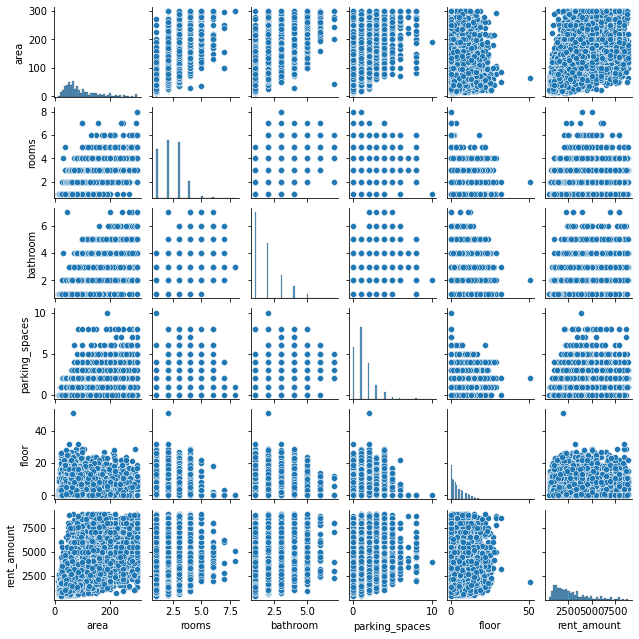

In [734]:
display(sn.pairplot(quantitative_data_no_outliers, height=1.5))

In [735]:
train, test = generate_random_train_test(quantitative_data_no_outliers, percent_train=0.7)

X_train = train[['area', 'rooms', 'bathroom', 'parking_spaces', 'floor']]
y_train = train['rent_amount']

X_test = test[['area', 'rooms', 'bathroom', 'parking_spaces', 'floor']]
y_test = test['rent_amount']


Bases de Treino e Teste geradas com sucesso!
A base de Treino possui 6343 conjuntos de dados
A base de Teste possui 2719 conjuntos de dados


In [736]:
# Utilizando o modelo de regressão linear multipla
linear = linear_regress(y_train, X_train.drop(['area'], axis=1))
y_pred = linear.predict(sm.add_constant(X_test.drop(['area'], axis=1)))
linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            rent_amount   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     1008.
Date:                Thu, 01 Dec 2022   Prob (F-statistic):               0.00
Time:                        20:39:37   Log-Likelihood:                -55170.
No. Observations:                6343   AIC:                         1.103e+05
Df Residuals:                    6338   BIC:                         1.104e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            530.6447     50.466     10.515      0.000     431.715     629.575
rooms            155.6539     25.470      6.111      0.000     105.724     205.584
bathroom         721.6105     25.762     28.010      0.000     671.108     772.113
parking_spaces   267.1803     19.952     13.391      0.000     228.067     306.294
floor             48.4122      3.591     13.482      0.000      41.373      55.452
==============================================================================
Omnibus:                     1208.310   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2331.194
Skew:                           1.161   Prob(JB):                         0.00
Kurtosis:                       4.851   Cond. No.                         22.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [737]:
# Armazenando os erros
errors['linear_2'] = [mean_squared_error(y_test, y_pred, squared=False), mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)]

In [738]:
# Utilizando o modelo de regressão por árvore de decisão
decision_tree = decision_tree_regress(X_train, y_train)
y_pred = decision_tree.predict(X_test)

# Armazenando os erros
errors['decision_tree_2'] = [mean_squared_error(y_test, y_pred, squared=False), mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)]

In [739]:
# Utilizando o modelo de regressão por floresta aleatória
random_forest = random_forest_regress(X_train, y_train)
y_pred = random_forest.predict(X_test)

# Armazenando os erros
errors['random_forest_2'] = [mean_squared_error(y_test, y_pred, squared=False), mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)]

In [740]:
# Utilizando o modelo de regressão por k-vizinhos mais próximos
K_neighbors = K_neighbors_regress(X_train, y_train, 6000)
y_pred = K_neighbors.predict(X_test)

# Armazenando os erros
errors['K_neighbors_2'] = [mean_squared_error(y_test, y_pred, squared=False), mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)]

In [741]:
errors

,type,linear_1,decision_tree_1,random_forest_1,K_neighbors_1,linear_2,decision_tree_2,random_forest_2,K_neighbors_2
0,rmse,2490.693058,3242.008148,2419.746854,3486.738269,1383.132019,1776.473741,1408.998437,1799.223352
1,mae,1691.580461,2022.962636,1600.586314,2749.097235,1039.649059,1230.751692,1009.506895,1444.714817
2,r2,0.482148,0.122609,0.511230,-0.014854,0.404716,0.017993,0.382242,-0.007319


_____
## Conclusões



In [742]:
errors

,type,linear_1,decision_tree_1,random_forest_1,K_neighbors_1,linear_2,decision_tree_2,random_forest_2,K_neighbors_2
0,rmse,2490.693058,3242.008148,2419.746854,3486.738269,1383.132019,1776.473741,1408.998437,1799.223352
1,mae,1691.580461,2022.962636,1600.586314,2749.097235,1039.649059,1230.751692,1009.506895,1444.714817
2,r2,0.482148,0.122609,0.511230,-0.014854,0.404716,0.017993,0.382242,-0.007319


   A respeito dos dados trabalhados chegou-se à conclusão de que não é possível prever com uma precisão adequada o valor de um imóvel com base nas variáveis escolhidas e no modelo de previsão atual.
   
   Foram utilizados os métodos de predição: Regressão Linear Múltipla, Árvore de Decisão, Floresta Aleatória e K-Vizinhos Mais Próximos, além de  métricas de avaliação de séries temporais como MSE (Erro Quadrático Médio) e MAE (Erro Médio Absoluto), sendo o modelo de Regressão Linear o que melhor obteve êxito no cálculo dos erros, tanto na primeira quanto na segunda iteração. Sendo o valor do erro MSE da primeira iteração da Regressão Linear de aproximadamente 2488,85 reais, e o da segunda, 1316,70 reais. Já os valores da Regressão Linear no tipo de erro MAE foram para a primeira e a segunda iteração, respectivamente: 
	
   Entretanto, mesmo sendo o método com melhores resultados, seu uso seria inadequado, visto que o Prob(Omnibus) e o Prob(JB) resultaram em zero, o que indica que os resíduos não seguem distribuição normal, o que violaria a suposição de modelo de regressão. 
    
   Para uma melhor previsão e uma melhor adequação do modelo de regressão, poderiam ser feitos ajustes nas variáveis explicativas, já que inicialmente foram descartadas as variáveis qualitativas (‘animal’ e 'furniture'). Caso fossem transformadas em quantitativas, testes poderiam ser feitos para garantir uma melhor predição dos valores dos imóveis. 


In [743]:
# Possível 3 iteração

#  As variaveis `animal` e `furniture` são variaveis qualitativas que possuem apenas dois valores: 
#  `possui/aceita` e não `possui/não aceita`. Logo, para padronizar essas variaveis, substituiremos 
#  esses valores por `True` e `False`, respectivamente.

#  data.loc[(data['animal'] == 'acept'), 'animal'] = True
#  data.loc[(data['animal'] == 'not acept'), 'animal'] = False
#  data['animal'] = data['animal'].astype('boolean')

#  data.loc[(data['furniture'] == 'furnished'), 'furniture'] = True
#  data.loc[(data['furniture'] == 'not furnished'), 'furniture'] = False
#  data['furniture'] = data['furniture'].astype('boolean') 

___
## Referências

- https://www.geeksforgeeks.org/python-decision-tree-regression-using-sklearn/
- https://towardsdatascience.com/what-are-the-best-metrics-to-evaluate-your-regression-model-418ca481755b
- https://stackoverflow.com/questions/17197492/is-there-a-library-function-for-root-mean-square-error-rmse-in-python
- https://medium.com/pursuitnotes/decision-tree-regression-in-6-steps-with-python-1a1c5aa2ee16
- https://stackabuse.com/decision-trees-in-python-with-scikit-learn/